# import uci dataset



In [ ]:
import pandas as pd

# Load directly from UCI repository URL
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

columns = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race",
    "sex", "capital-gain", "capital-loss", "hours-per-week",
    "native-country", "income"
]

train_data = pd.read_csv(url, header=None, names=columns, na_values=" ?", skipinitialspace=True)
train_data['income'] = train_data['income'].str.rstrip('.')
train_data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [ ]:
attributes_to_ignore = ['capital-gain','capital-loss']     # attributes with unique values such as names and ids that dont hold any information for the data and make learning harder
discrete_columns = ['workclass','education','marital-status','occupation','relationship','race','sex','native-country','income']
train_data = train_data.drop(attributes_to_ignore, axis = 1)
train_data = train_data.dropna()
train_data = train_data.reset_index(drop=True)

In [ ]:
def rename_categorical_values(df):
    df = df.copy()  # Avoid modifying original DataFrame
    for col in df.select_dtypes(include=['object', 'category']).columns:
        unique_vals = df[col].unique()
        for val in unique_vals:
            if isinstance(val, str):
                # Find if this value exists in multiple columns
                count = sum((df[c] == val).any() for c in df.select_dtypes(include=['object', 'category']).columns)
                if count > 1:
                    df[col] = df[col].replace(val, f"{val}_{col}")
    return df

train_data = rename_categorical_values(train_data)

In [ ]:
num_features = 10
num_negatives = 5
discrete_columns = [c for c in train_data.columns if c in discrete_columns]    # puts disrete_columns in the right order

discrete_df = train_data[discrete_columns]

# Import csv dataset

In [ ]:
from google.colab import files

files.upload()    # Upload the training data csv. The following implementation drops the null values. Custom handling before uploading is encouraged

In [ ]:
dataset_name = '...'      # use the name .csv file imported above
discrete_columns = []
attributes_to_ignore = []     # attributes with unique values such as names and ids that dont hold any information for the data and make learning harder

num_features = 15
num_negatives = 5

In [ ]:
import pandas as pd

train_data = pd.read_csv(dataset_name)
train_data = train_data.dropna().reset_index(drop=True)
train_data = train_data.drop(attributes_to_ignore, axis = 1)
discrete_columns = [c for c in train_data.columns if c in discrete_columns]    # puts disrete_columns in the right order

discrete_df = train_data[discrete_columns]

# Embeddings


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import random
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset


class EmbeddingsNN(nn.Module):
    def __init__(self, discrete_df, num_features, num_negatives, pairs_pc, batch_size = 4000):
        """
        Initialize the embedding model.

        Args:
            discrete_df (pd.DataFrame): DataFrame with only discrete categorical columns.
            num_features (int): Embedding dimension size.
            num_negatives (int): Number of negative samples per positive sample.
            pairs_pc (float): Percentage of column pairs to sample for training.
            batch_size (int, optional): Batch size for training. Defaults to 4000.
        """
        super(EmbeddingsNN, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.criterion = nn.BCELoss()
        self.num_epochs = 150
        self.num_negatives = num_negatives
        self.pairs_pc = pairs_pc
        self.batch_size = batch_size
        self.negtive_samples = []
        self.discrete_columns = discrete_df.columns
        self.num_words = self.compute_num_words(discrete_df)
        self.num_features = num_features
        self.f_matrix = self.get_f_matrix(self.word_occurance_pairs)
        self.column_pairs= [
        (col1, col2)
        for col1 in self.discrete_columns
        for col2 in self.discrete_columns
        if col1 != col2
        ]

        # E is the matrix we want to learn
        self.one_hot_matrix = torch.eye(self.num_words, device=self.device)
        self.E = nn.Parameter(torch.empty(self.num_words, self.num_features, device=self.device))  # Matrix E (learnable)
        self.theta = nn.Parameter(torch.empty(self.num_features, self.num_words, device=self.device))  # Vector θ (learnable)

        nn.init.xavier_uniform_(self.E)
        nn.init.xavier_uniform_(self.theta)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001, weight_decay=1e-5)

        self.to(self.device)


    def forward(self, idx_c, idx_t, batched=False):
        """
        Forward pass computes probability of co-occurrence between center and target words.

        Args:
            idx_c (Tensor or int): Indices of center words (batch or single).
            idx_t (Tensor or int): Indices of target words (batch or single).
            batched (bool): If True, treat inputs as batches.

        Returns:
            Tensor: Sigmoid probability of co-occurrence.
        """
        e_c = self.E[idx_c]
        theta_t = self.theta[:, idx_t]
        if batched:
            return torch.sigmoid(torch.sum((e_c *(theta_t.T)), dim=1))
        else:
            return torch.sigmoid(torch.dot(e_c, theta_t))

    def compute_num_words(self, discrete_df):
        """
        Compute the total number of unique discrete values ("words") and
        build word-to-index mapping.

        Args:
            discrete_df (pd.DataFrame): Input categorical data.

        Returns:
            int: Total number of unique words.
        """

        self.word_occurance_pairs = []
        self.values_per_column = [0]*len(self.discrete_columns)
        for column in self.discrete_columns:
            value_counts_pairs = discrete_df[column].value_counts().items()
            for v,c in value_counts_pairs:
              self.word_occurance_pairs.append([v,c])
              self.values_per_column[self.discrete_columns.get_loc(column)] += 1

        self.words = [word for word, count in self.word_occurance_pairs]
        self.word_to_idx = {word: idx for idx, word in enumerate(self.words)}
        return len(self.words)

    def get_f_matrix(self, word_occurance_pairs):
        """
        Compute negative sampling probabilities for each word.

        Args:
            word_occurance_pairs (list): List of [word, count] pairs.

        Returns:
            list: List of [index, probability] for negative sampling.
        """
        total = sum(x[1] for x in word_occurance_pairs)
        for i in range(len(word_occurance_pairs)):
          word_occurance_pairs[i][1] = word_occurance_pairs[i][1]/total
        sum_of_fs = sum(x[1]**(3/4) for x in word_occurance_pairs)
        f_matrix =[]
        for i in range(len(word_occurance_pairs)):
            f_matrix.append([i, word_occurance_pairs[i][1]**(3/4)/sum_of_fs])
        return f_matrix


    def get_training_pairs(self, pairs_pc, total_batch):
        """
        Sample positive training pairs (center-target) from random column pairs.

        Args:
            pairs_pc (float): Percentage of column pairs to sample.
            total_batch (pd.DataFrame): Current batch of data.

        Returns:
            Tensor: Training pairs of word indices with shape (num_pairs, 2).
        """
        num_pairs = int(len(self.column_pairs)*pairs_pc)
        pairs_set = random.sample(self.column_pairs, k=num_pairs)
        training_pairs = []
        for c, t in pairs_set:
          centers = total_batch[c].map(self.word_to_idx)
          targets = total_batch[t].map(self.word_to_idx)
          pairs = torch.stack([
              torch.tensor(centers.values, device=self.device),
              torch.tensor(targets.values, device=self.device)
          ], dim=1)
          training_pairs.append(pairs)

        # Concatenate all pairs from all column combinations
        training_pairs = torch.cat(training_pairs, dim=0)
        return training_pairs


    def get_negative_samples(self, positive_idxs, num_negatives):
        """
        Generate negative samples for each positive target index.

        Args:
            positive_idxs (Tensor): Indices of positive target words.
            num_negatives (int): Number of negatives to sample per positive.

        Returns:
            Tensor: Negative samples with shape (batch_size, num_negatives).
        """

        neg_samples = []
        numbers, probabilities = zip(*self.f_matrix)
        for _ in range(num_negatives):
            r = random.choices(numbers, weights=probabilities, k=len(positive_idxs))
            neg_samples.append(r)
        return torch.tensor(neg_samples, device = self.device).T


    def train(self):
        num_samples = len(discrete_df)
        counter = 0

        for epoch in range(self.num_epochs):
            total_loss = 0

            for i in range(0, num_samples, self.batch_size):
                counter+=1
                batch_df = discrete_df.iloc[i:i+self.batch_size]
                if len(batch_df) == 0:
                    continue

                training_pairs = self.get_training_pairs(self.pairs_pc, batch_df)
                targets = training_pairs[:, 1]
                negative_samples = self.get_negative_samples(targets, self.num_negatives)

                tp_exp = training_pairs[:, 0].repeat_interleave(negative_samples.shape[1])
                negative_samples = negative_samples.flatten()
                negative_samples = torch.stack([tp_exp, negative_samples], dim=1)

                self.optimizer.zero_grad()

                pos_scores = self.forward(training_pairs[:,0], training_pairs[:,1], batched=True)
                pos_loss = self.criterion(pos_scores, torch.ones_like(pos_scores))

                neg_scores = self.forward(negative_samples[:,0], negative_samples[:,1], batched=True)
                neg_loss = self.criterion(neg_scores, torch.zeros_like(neg_scores))

                loss = (pos_loss + neg_loss)
                loss.backward()
                self.optimizer.step()

                total_loss += loss.item()

            if epoch%10 == 0:
                print(f"Epoch {epoch}, Loss: {total_loss:.4f}")



In [ ]:
pair_prob = 0.3  # the probability of selecting a positive sample for training in a given epoch
ebd = EmbeddingsNN(discrete_df, num_features, num_negatives, pair_prob)
ebd.train()

In [ ]:
E = torch.tanh(ebd.E.T).detach().cpu().numpy()
embeddings_df = pd.DataFrame(E, columns = ebd.words)

In [ ]:
embeddings_df = (embeddings_df - embeddings_df.mean()) / embeddings_df.std()

In [ ]:
#normalize the values of the embeddings
max = embeddings_df.abs().max().max()
embeddings_df = (embeddings_df / max).astype('float32')

#apply embeddings on words
def word_to_vec(word):
    if word in embeddings_df.columns.tolist():
       return embeddings_df[word].values

#construct the new dataframe with continuous ad embedded columns
def construct_dataset(train_df):
    i=0
    _df = train_df.copy()
    cat_col_pos = []
    for column in _df:
       if column in discrete_columns:
          cat_col_pos.append(column)
          _df[column] = _df[column].apply(lambda x: word_to_vec(x))
       else:
          cat_col_pos.append(None)
    return _df, cat_col_pos

new_df, cat_cols_pos = construct_dataset(train_data)

In [ ]:
new_rows = []
for _, row in new_df.iterrows():
    flat = []
    for val in row:
        if isinstance(val, (list, np.ndarray)):
            flat.extend(val)  # unpack lists or arrays
        else:
            flat.append(val)  # keep scalar values
    new_rows.append(flat)

new_rows = np.asarray(new_rows)

# Step eval

In [ ]:
from scipy.stats import wasserstein_distance

def avg_num_w_dist(real_data, model_data):
    dists = 0
    for c in range(real_data.shape[1]):
        dists += wasserstein_distance(real_data[:,c], model_data[:,c])
    avg_dists = dists/real_data.shape[1]
    return avg_dists

In [ ]:
import numpy as np

def L2_correlation_matrices(real_data, model_data):
        # Compute correlation matrices
        corr1 = np.corrcoef(real_data, rowvar=False)
        corr2 = np.corrcoef(model_data, rowvar=False)

        # Compute the L2 (Euclidean) distance between the flattened matrices
        l2_distance = np.linalg.norm(corr1 - corr2)

        return l2_distance



# eGAN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.nn import BatchNorm1d, Dropout, LeakyReLU, Linear, Module, ReLU, Sequential, functional
from torch.autograd import grad


class Residual(Module):
    """Residual layer for the eGAN."""

    def __init__(self, i, o):
        super(Residual, self).__init__()
        self.fc = Linear(i, o)
        self.bn = BatchNorm1d(o)
        self.relu = ReLU()

    def forward(self, input_):
        """Apply the Residual layer to the `input_`."""
        out = self.fc(input_)
        out = self.bn(out)
        out = self.relu(out)
        return out


# ==== Generator ====
class Generator(nn.Module):
    def __init__(self, embedding_dim, generator_dims, data_dim):
        super(Generator, self).__init__()
        dim = embedding_dim
        seq = []
        for item in list(generator_dims):
            seq += [Residual(dim, item)]
            dim = item
        seq.append(Linear(dim, data_dim))
        self.seq = Sequential(*seq)

    def forward(self, input_):
        """Apply the Generator to the `input_`."""
        data = self.seq(input_)
        return data


# ==== Discriminator ====
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, x):
        return self.model(x)

def compute_gradient_penalty(critic, real_data, fake_data, device, l=2):
    """
    Computes the gradient penalty for WGAN-GP.

    Args:
        critic (nn.Module): Discriminator/critic model.
        real_data (Tensor): Real data batch, shape (batch_size, data_dim).
        fake_data (Tensor): Fake data batch, shape (batch_size, data_dim).
        device (torch.device): Device on which tensors are allocated.
        l (float, optional): Gradient penalty coefficient (lambda). Default is 2.

    Returns:
        Tensor: Scalar gradient penalty loss.
    """
    batch_size = real_data.size(0)
    epsilon = torch.rand(batch_size, 1, device=device)
    epsilon = epsilon.expand_as(real_data)

    interpolated = epsilon * real_data + (1 - epsilon) * fake_data
    interpolated.requires_grad_(True)

    prob_interpolated = critic(interpolated)
    gradients = grad(outputs=prob_interpolated, inputs=interpolated,
                     grad_outputs=torch.ones_like(prob_interpolated),
                     create_graph=True, retain_graph=True)[0]

    gradients = gradients.view(batch_size, -1)
    gradient_norm = gradients.norm(2, dim=1)
    penalty = ((gradient_norm - 1) ** 2).mean()
    return penalty*l


class eGAN():
    def __init__(self, embedding_dim=128, generator_dims=(256, 512, 1024, 512, 256), discriminator_dim=512, discriminator_steps=1, epochs=800, batch_size=2000, cuda=True):
        """
        Initialize eGAN with hyperparameters.

        Args:
            embedding_dim (int): Latent vector size for Generator input.
            generator_dims (tuple): Generator hidden layer dimensions.
            discriminator_dim (int): Discriminator hidden layer size.
            discriminator_steps (int): Number of discriminator updates per generator update.
            epochs (int): Number of training epochs.
            batch_size (int): Training batch size.
            cuda (bool or str): Whether to use GPU, or specify GPU device string.
        """
        self.embedding_dim = embedding_dim
        self.generator_dims = generator_dims
        self.discriminator_dim = discriminator_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.discriminator_steps = discriminator_steps
        self.criterion = nn.BCELoss()


        if not cuda or not torch.cuda.is_available():
            device = 'cpu'
        elif isinstance(cuda, str):
            device = cuda
        else:
            device = 'cuda'

        self.device = torch.device(device)

    def fit(self, data):
        self.data_dim = data.shape[1]
        self.data = torch.tensor(data, dtype=torch.float32).to(self.device)

        self.generator = Generator(self.embedding_dim, self.generator_dims, self.data_dim).to(self.device)
        self.discriminator = Discriminator(self.data_dim, self.discriminator_dim).to(self.device)

        self.optimizer_D = optim.Adam(self.discriminator.parameters(), lr=4e-4, betas=(0.5, 0.9))
        self.optimizer_G = optim.Adam(self.generator.parameters(), lr=1e-4, betas=(0.5, 0.9))

        data_loader = torch.utils.data.DataLoader(self.data, batch_size=self.batch_size)

        fixed_real_labels = torch.ones((self.batch_size, 1), device=self.device)
        fixed_fake_labels = torch.zeros((self.batch_size, 1), device=self.device)

        self.avg_w_distances = []
        self.corr_l2_distances = []

        for epoch in range(self.epochs):
            for real_batch in data_loader:
                batch_size_curr = real_batch.size(0)
                real_labels = fixed_real_labels[:batch_size_curr]
                fake_labels = fixed_fake_labels[:batch_size_curr]

                #Train Discriminator
                for i in range(self.discriminator_steps):
                    d_real = self.discriminator(real_batch)

                    z = torch.randn(batch_size_curr, self.embedding_dim, device=self.device)
                    fake_data = self.generator(z)
                    d_fake = self.discriminator(fake_data.detach())

                    loss_real = -torch.mean(d_real)
                    loss_fake = torch.mean(d_fake)

                    gp = compute_gradient_penalty(self.discriminator, real_batch, fake_data.detach(), self.device)

                    loss_D = loss_real + loss_fake

                    self.optimizer_D.zero_grad()
                    gp.backward(retain_graph=True)
                    loss_D.backward()
                    self.optimizer_D.step()

                #Train Generator
                z = torch.randn(batch_size_curr, self.embedding_dim, device=self.device)
                generated_data = self.generator(z)
                outputs = self.discriminator(generated_data)

                loss_G = -torch.mean(outputs)

                self.optimizer_G.zero_grad()
                loss_G.backward()
                self.optimizer_G.step()

            if epoch % 20 == 0:
                curr_samples = self.sample(1000)
                avg_w_dist = avg_num_w_dist(data, curr_samples)
                self.avg_w_distances.append(avg_w_dist)
                l2_dist = L2_correlation_matrices(data, curr_samples)
                self.corr_l2_distances.append(l2_dist)
                print(f"Epoch {epoch} | Loss D: {loss_D.item():.4f} | Loss G: {loss_G.item():.4f}")

        return self.avg_w_distances, self.corr_l2_distances

    def sample(self, num_samples):
        with torch.no_grad():
            z = torch.randn(num_samples, self.embedding_dim, device=self.device)
            generated_data = self.generator(z)
        return generated_data.cpu().numpy()

In [ ]:
#Training
from sklearn.preprocessing import StandardScaler

l_nr = np.log1p(new_rows+0.01)  #For smoothing. It compresses large values and expands small ones

scaler = StandardScaler()
X_scaled = scaler.fit_transform(l_nr)

egan = eGAN()
res = egan.fit(X_scaled)

Epoch 0 | Loss D: -8.4241 | Loss G: -4.1613
Epoch 20 | Loss D: -2.1206 | Loss G: -1.8788
Epoch 40 | Loss D: -1.7070 | Loss G: -1.2442
Epoch 60 | Loss D: -1.7301 | Loss G: 1.3064
Epoch 80 | Loss D: -1.6417 | Loss G: 2.1672
Epoch 100 | Loss D: -1.8566 | Loss G: 2.9672
Epoch 120 | Loss D: -1.9162 | Loss G: 2.8913
Epoch 140 | Loss D: -1.5772 | Loss G: 2.6081
Epoch 160 | Loss D: -1.5857 | Loss G: 1.9929
Epoch 180 | Loss D: -1.3522 | Loss G: 2.1806
Epoch 200 | Loss D: -1.5373 | Loss G: 1.9958
Epoch 220 | Loss D: -1.3357 | Loss G: 2.3621
Epoch 240 | Loss D: -1.3661 | Loss G: 2.1810
Epoch 260 | Loss D: -1.3708 | Loss G: 3.2709
Epoch 280 | Loss D: -1.4861 | Loss G: 3.1019
Epoch 300 | Loss D: -1.5402 | Loss G: 2.5529
Epoch 320 | Loss D: -1.1031 | Loss G: 1.9228
Epoch 340 | Loss D: -1.2595 | Loss G: 2.6278
Epoch 360 | Loss D: -1.0848 | Loss G: 2.5676
Epoch 380 | Loss D: -1.1435 | Loss G: 1.9106
Epoch 400 | Loss D: -0.8083 | Loss G: 1.7336
Epoch 420 | Loss D: -1.1025 | Loss G: 2.2230
Epoch 440 | L

#Plotting progression graphs

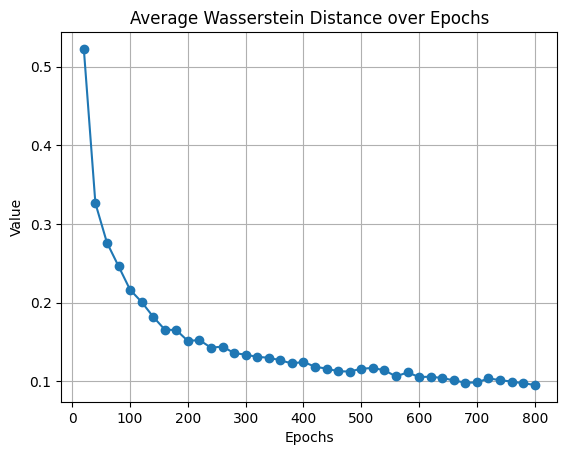

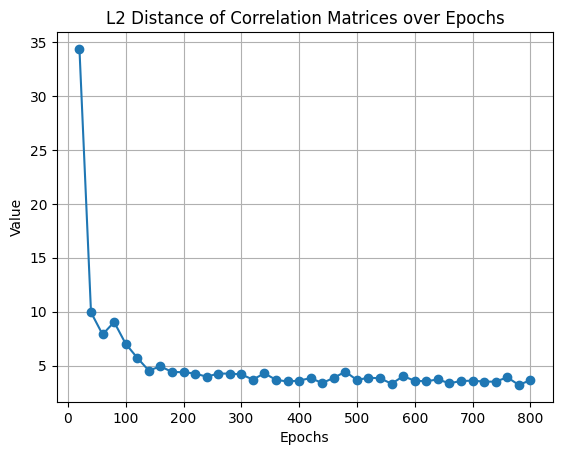

In [ ]:
import matplotlib.pyplot as plt

values = res[0]

# Epochs corresponding to each value
epochs = [20 * (i + 1) for i in range(len(values))]

# Plot
plt.plot(epochs, values, marker='o')
plt.title("Average Wasserstein Distance over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.grid(True)
plt.show()

values = res[1]

# Epochs corresponding to each value
epochs = [20 * (i + 1) for i in range(len(values))]

# Plot
plt.plot(epochs, values, marker='o')
plt.title("L2 Distance of Correlation Matrices over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.grid(True)
plt.show()

#Sampling

In [ ]:
def get_discrete_values(tmp, start, end):
    X = embeddings_df.iloc[:, start : end]
    res=[]
    score = float('inf')
    for x in tmp:
        att=None
        score = float('inf')
        for v in X:
            s = nn.CosineEmbeddingLoss()(torch.tensor(X[v].values).unsqueeze(0), torch.tensor(x).unsqueeze(0), torch.ones(x.shape))
            if (s<score):
               score=s
               att=v
        res.append(att)
    return res

def create_final_df(sample, columns, discrete_columns, num_features):
    final_df = pd.DataFrame()
    i=0
    j=0
    col_atts_indeces = np.concatenate([np.zeros(1).astype(int), np.cumsum(ebd.values_per_column)])
    for c in columns:
        if c in discrete_columns:
            tmp = sample[:,i:i+num_features]
            attributes = get_discrete_values(tmp, col_atts_indeces[j], col_atts_indeces[j+1])
            j+=1
            final_df[c] = attributes
            i+=num_features
        else:
            final_df[c] = sample[:,i]
            i+=1
    return final_df

In [ ]:
d = egan.sample(5000)

samples = scaler.inverse_transform(d)
samples = np.expm1(samples)

In [ ]:
final_df = create_final_df(samples, new_df.columns, discrete_columns, num_features)

In [ ]:
i_df = final_df.copy()
i_df['age'] = i_df['age'].astype(int)
i_df['hours-per-week'] = i_df['hours-per-week'].astype(int)
i_df['education-num'] = i_df['education-num'].astype(int)
i_df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income
0,70,Local-gov,167282.109375,11th,7,Married-civ-spouse,Other-service,Husband,Black,Male,36,United-States,<=50K
1,43,Private,108043.625000,HS-grad,8,Married-civ-spouse,Craft-repair,Husband,White,Male,38,United-States,>50K
2,51,Private,328103.031250,Bachelors,12,Married-civ-spouse,Prof-specialty,Husband,White,Male,41,United-States,>50K
3,33,Private,156282.343750,HS-grad,8,Married-civ-spouse,Handlers-cleaners,Unmarried,Asian-Pac-Islander,Female,46,Vietnam,<=50K
4,103,?_workclass,61721.046875,HS-grad,8,Married-civ-spouse,?_occupation,Husband,White,Male,19,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,42,Private,204711.828125,HS-grad,8,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,41,United-States,<=50K
4996,28,Private,345994.781250,10th,5,Married-civ-spouse,Craft-repair,Husband,White,Male,38,United-States,<=50K
4997,20,Private,116440.242188,11th,7,Never-married,Craft-repair,Own-child,White,Male,29,United-States,<=50K
4998,28,Self-emp-not-inc,190962.156250,HS-grad,9,Divorced,Craft-repair,Not-in-family,White,Male,68,United-States,<=50K


from matplotlib import pyplot as plt
i_df['age'].plot(kind='hist', bins=20, title='age')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
i_df['fnlwgt'].plot(kind='hist', bins=20, title='fnlwgt')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
i_df['education-num'].plot(kind='hist', bins=20, title='education-num')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
i_df['hours-per-week'].plot(kind='hist', bins=20, title='hours-per-week')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
i_df.groupby('workclass').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
i_df.groupby('marital-status').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
i_df.groupby('relationship').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
i_df.groupby('race').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
i_df.plot(kind='scatter', x='age', y='fnlwgt', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
i_df.plot(kind='scatter', x='fnlwgt', y='education-num', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
i_df.plot(kind='scatter', x='education-num', y='hours-per-week', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
i_df['age'].plot(kind='line', figsize=(8, 4), title='age')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
i_df['fnlwgt'].plot(kind='line', figsize=(8, 4), title='fnlwgt')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
i_df['education-num'].plot(kind='line', figsize=(8, 4), title='education-num')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
i_df['hours-per-week'].plot(kind='line', figsize=(8, 4), title='hours-per-week')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['marital-status'].value_counts()
    for x_label, grp in i_df.groupby('workclass')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('workclass')
_ = plt.ylabel('marital-status')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['relationship'].value_counts()
    for x_label, grp in i_df.groupby('marital-status')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('marital-status')
_ = plt.ylabel('relationship')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['race'].value_counts()
    for x_label, grp in i_df.groupby('relationship')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('relationship')
_ = plt.ylabel('race')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['sex'].value_counts()
    for x_label, grp in i_df.groupby('race')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('race')
_ = plt.ylabel('sex')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(i_df['workclass'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(i_df, x='age', y='workclass', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(i_df['marital-status'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(i_df, x='age', y='marital-status', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(i_df['relationship'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(i_df, x='age', y='relationship', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(i_df['race'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(i_df, x='age', y='race', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
from google.colab import files

i_df.to_csv('final_df.csv', index=False)
files.download('final_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>